In [1]:
#Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import pandas_ta as ta
import yfinance as yf
from backtesting import Backtest, Strategy
from alpha_vantage.timeseries import TimeSeries
import requests

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
#OLD CODE USING YFINANCE
"""#Download asset data
df = yf.download(tickers="AAPL", start='2010-01-01', end='2023-12-31')

#calculatre technical indicators
df['MA'] = ta.ema(df['Close'], length=20)
df['rsi'] = ta.rsi(df['Close'], length=14)
df['coppock'] = ta.coppock(df['Close'], length=12)
df['returns'] = df['Close'].pct_change(-1) * 100 * -1
df['forecast_tommorrow'] = np.where(df['returns'] > 0,
                                   1,
                                   0) #1 is for UP and 0 is for down

df = df.dropna()
df"""

'#Download asset data\ndf = yf.download(tickers="AAPL", start=\'2010-01-01\', end=\'2023-12-31\')\n\n#calculatre technical indicators\ndf[\'MA\'] = ta.ema(df[\'Close\'], length=20)\ndf[\'rsi\'] = ta.rsi(df[\'Close\'], length=14)\ndf[\'coppock\'] = ta.coppock(df[\'Close\'], length=12)\ndf[\'returns\'] = df[\'Close\'].pct_change(-1) * 100 * -1\ndf[\'forecast_tommorrow\'] = np.where(df[\'returns\'] > 0,\n                                   1,\n                                   0) #1 is for UP and 0 is for down\n\ndf = df.dropna()\ndf'

In [3]:
def ticker_data_download(ticker):
    """
    Function to download ticker daily data from alpha vantage.
    It returns a pandas data frame.
    Use your own API.
    You need to import library pandas_ta
    """
    #import alpha vantage API from a text file
    with open('myAPI.txt', 'r') as file:
        api_key = file.read()
    # Initialize Alpha Vantage API client
    ts = TimeSeries(key=api_key, output_format='pandas')
    symbol = ticker
    #Download ticker data
    data, meta_data = ts.get_daily(symbol=symbol, outputsize='full')
    df = data
    #rename columns
    df.rename(columns={
        '1. open': 'Open',
        '2. high': 'High',
        '3. low': 'Low',
        '4. close': 'Close',
        '5. volume': 'Volume'
    }, inplace=True)
    #Calculate indicators with pandas_ta
    df['MA'] = ta.ema(df['Close'], length=20)
    df['rsi'] = ta.rsi(df['Close'], length=14)
    df['coppock'] = ta.coppock(df['Close'], length=12)
    df['returns'] = df['Close'].pct_change(-1) * 100 * -1
    df['forecast_tommorrow'] = np.where(df['returns'] > 0,
                                       1,
                                       0) #1 is for UP and 0 is for down
    df = df.dropna()
    return df

In [4]:
df = ticker_data_download('IBM')
df

,Open,High,Low,Close,Volume,MA,rsi,coppock,returns,forecast_tommorrow
date,,,,,,,,,,
2024-01-26,191.31,192.3896,186.16,187.42,9895941.0,185.789143,52.178392,1.169031,1.580633,1
2024-01-25,184.96,196.9000,184.83,190.43,29596239.0,186.231129,58.773930,2.014613,-9.486575,0
2024-01-24,174.76,174.8600,172.90,173.93,7831157.0,185.059593,32.396709,0.143206,0.005749,1
2024-01-23,172.90,174.0200,172.48,173.94,3983461.0,184.000584,32.416505,-1.731807,-0.642250,0
2024-01-22,172.82,174.4500,172.40,172.83,4925964.0,182.936719,31.320155,-3.629758,-0.787264,0
...,...,...,...,...,...,...,...,...,...,...
1999-11-08,90.50,93.9400,90.50,93.94,8522300.0,100.260386,34.731247,-21.713106,-4.088643,0
1999-11-05,92.75,92.9400,90.19,90.25,13737600.0,99.307016,30.510807,-23.145898,1.430756,1
1999-11-04,94.44,94.4400,90.00,91.56,16697600.0,98.569205,33.595856,-23.372568,2.977641,1


<AxesSubplot: >

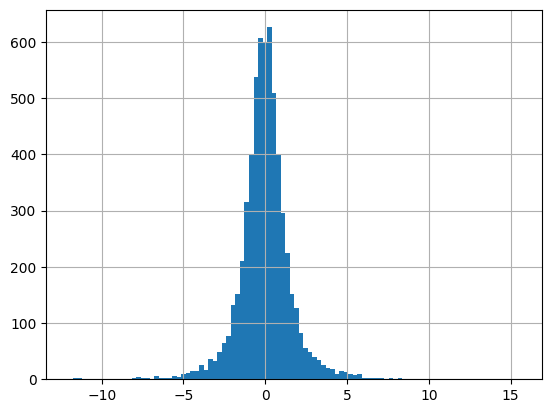

In [5]:
#Plot asset returns histogram
df['returns'].hist(bins=100) # is the skew positive or negative?

In [6]:
# Separate features and target variable
X = df.drop(columns=['forecast_tommorrow'])
y = df['forecast_tommorrow']

In [7]:
#split data into trains and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
#scale variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
model = XGBClassifier()

In [10]:
model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [11]:
y_pred = model.predict(X_test_scaled)
y_pred

array([1, 1, 1, ..., 0, 0, 1])

In [12]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9975409836065574
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       608
           1       1.00      1.00      1.00       612

    accuracy                           1.00      1220
   macro avg       1.00      1.00      1.00      1220
weighted avg       1.00      1.00      1.00      1220



In [13]:
compare = pd.DataFrame(y_test)
compare['predictions'] = y_pred
compare.head(50)

,forecast_tommorrow,predictions
date,,
2000-09-11,1,1
2014-10-09,1,1
2018-03-06,1,1
2021-11-01,0,0
2008-08-22,0,0
2014-09-15,0,0
2023-01-09,1,1
2015-07-20,0,0
2004-01-08,0,0


Aplicaçao do modelo em novos dados

In [14]:
#Download asset data
df_new_stock = yf.download(tickers="MSFT")

#calculatre technical indicators
df_new_stock['MA'] = ta.ema(df_new_stock['Close'], length=20)
df_new_stock['rsi'] = ta.rsi(df_new_stock['Close'], length=14)
df_new_stock['coppock'] = ta.coppock(df_new_stock['Close'], length=12)
df_new_stock['returns'] = df_new_stock['Close'].pct_change(-1) * 100 * -1
df_new_stock['forecast_tommorrow'] = np.where(df_new_stock['returns'] > 0,
                                   1,
                                   0) #1 is for UP and 0 is for down
df_new_stock = df_new_stock.drop(['Adj Close'], axis=1)
df_new_stock = df_new_stock.dropna()
df_new_stock

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,MA,rsi,coppock,returns,forecast_tommorrow
Date,,,,,,,,,,
1986-04-18 00:00:00-05:00,0.105035,0.105035,0.100694,0.101563,21628800,0.098896,59.005425,12.142096,-0.000000,0
1986-04-21 00:00:00-05:00,0.101563,0.102431,0.098958,0.101563,22924800,0.099150,59.005425,12.943036,-1.740026,0
1986-04-22 00:00:00-05:00,0.101563,0.101563,0.099826,0.099826,15552000,0.099214,53.351414,13.109644,0.432871,1
1986-04-23 00:00:00-05:00,0.099826,0.100694,0.098958,0.100260,15609600,0.099314,54.523930,12.916247,9.055453,1
1986-04-24 00:00:00-05:00,0.100260,0.111979,0.099826,0.110243,62352000,0.100355,71.974104,15.382587,5.926374,1
...,...,...,...,...,...,...,...,...,...,...
2024-02-26 00:00:00-05:00,411.459991,412.160004,407.359985,407.540009,16193500,405.699201,54.365544,0.600164,-0.014724,0
2024-02-27 00:00:00-05:00,407.989990,408.320007,403.850006,407.480011,14835800,405.868802,54.299692,-0.119344,0.058862,1
2024-02-28 00:00:00-05:00,408.179993,409.299988,405.320007,407.720001,13183100,406.045106,54.536911,-0.830783,1.431199,1


<AxesSubplot: >

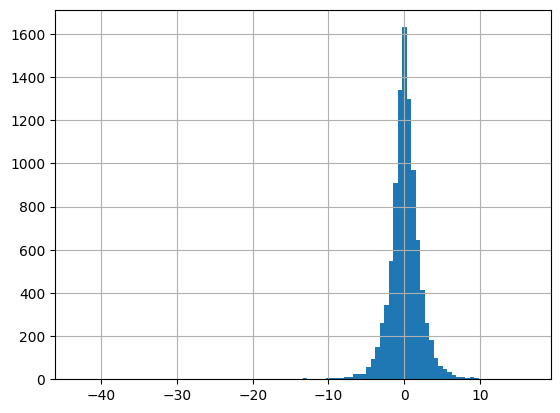

In [15]:
#Plot asset returns histogram
df_new_stock['returns'].hist(bins=100) # is the skew positive or negative?

In [16]:
# Separate features and target variable
X_new_stock = df_new_stock.drop(columns=['forecast_tommorrow'])
y_new_stock = df_new_stock['forecast_tommorrow']

In [17]:
scaler = StandardScaler()
X_new_stock_scaled = scaler.fit_transform(X_new_stock)
X_new_stock_scaled

array([[-0.66348855, -0.66398068, -0.66313495, ...,  0.4484857 ,
         0.8074958 , -0.03005097],
       [-0.66353084, -0.66401208, -0.66315631, ...,  0.4484857 ,
         0.87585682, -0.84211709],
       [-0.66353084, -0.66402255, -0.66314563, ..., -0.03401926,
         0.890077  ,  0.17196885],
       ...,
       [ 4.30643242,  4.27117254,  4.32241853, ...,  0.06714936,
        -0.29975266,  0.63788642],
       [ 4.312035  ,  4.33026997,  4.32980061, ...,  0.5373108 ,
        -0.27986038,  0.17886619],
       [ 4.3440653 ,  4.35041104,  4.3908251 , ...,  0.67160735,
        -0.27291945, -0.09528724]])

In [18]:
y_pred_new_stock = model.predict(X_new_stock_scaled)
y_pred_new_stock

array([0, 0, 1, ..., 1, 1, 0])

In [19]:
print("Accuracy: ", accuracy_score(y_new_stock, y_pred_new_stock))

Accuracy:  0.972338642078793


Create backtesting strategy

In [20]:
class trading_strategy(Strategy):
    n_train = 600
    coef_retrain = 200
    
    def init(self):
        self.model = XGBClassifier()
        self.model.fit(X=X_train, y=y_train)
        self.already_bought = False
        
    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :-1]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow == 1 and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow == 0 and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

In [21]:
"""class WalkForwardAnchored(Regression):
    def next(self):
        
        # we don't take any action and move on to the following day
        if len(self.data) < self.n_train:
            return
        
        # we retrain the model each 200 days
        if len(self.data) % self.coef_retrain == 0:
            X_train = self.data.df.iloc[:, :-1]
            y_train = self.data.df.iloc[:, -1]

            self.model.fit(X_train, y_train)

            super().next()
            
        else:
            
            super().next()"""

"class WalkForwardAnchored(Regression):\n    def next(self):\n        \n        # we don't take any action and move on to the following day\n        if len(self.data) < self.n_train:\n            return\n        \n        # we retrain the model each 200 days\n        if len(self.data) % self.coef_retrain == 0:\n            X_train = self.data.df.iloc[:, :-1]\n            y_train = self.data.df.iloc[:, -1]\n\n            self.model.fit(X_train, y_train)\n\n            super().next()\n            \n        else:\n            \n            super().next()"

In [22]:
bt = Backtest(df_new_stock, trading_strategy, cash=10000, commission=.002, exclusive_orders=True)

In [23]:
results = bt.run()
results

Start                     1986-04-18 00:00...
End                       2024-03-01 00:00...
Duration                  13832 days 00:00:00
Exposure Time [%]                   99.968567
Equity Final [$]          9061280061284205...
Equity Peak [$]           9227081591418639...
Return [%]                9061280061284205...
Buy & Hold Return [%]           409005.681516
Return (Ann.) [%]                 1181.854162
Volatility (Ann.) [%]              358.679864
Sharpe Ratio                         3.295011
Sortino Ratio                      104.994384
Calmar Ratio                        70.207028
Max. Drawdown [%]                  -16.833844
Avg. Drawdown [%]                   -1.403807
Max. Drawdown Duration       52 days 00:00:00
Avg. Drawdown Duration        6 days 00:00:00
# Trades                                 4853
Win Rate [%]                        79.435401
Best Trade [%]                      47.368692
Worst Trade [%]                    -14.638132
Avg. Trade [%]                    

Trade using Alpaca

In [24]:
#Read API keys from text file
with open('alpacaAPI.txt', 'r') as file:
    # Read the first line
    API_KEY, SECRET_KEY = file.read().split('\n')

In [25]:
import alpaca_trade_api as tradeapi

# Initialize the Alpaca API paper trading
api = tradeapi.REST(API_KEY,
                    SECRET_KEY,
                    base_url='https://paper-api.alpaca.markets')

# Submit a market order to buy 10 shares of AAPL
api.submit_order(
    symbol='ETH/USD',
    qty=1,
    side='buy',
    type='market',
    time_in_force='gtc'
)

APIError: forbidden.

Backtest other strategies

In [26]:
class trading_strategy2(Strategy):
    
    def init(self):
        self.already_bought = False
        
    def next(self):
        if self.data.df.coppock[-2] < 0 and self.data.df.coppock[-1] > 0 and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif self.data.df.coppock[-2] > 0 and self.data.df.coppock[-1] < 0 and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

In [27]:
# run the startegy
bt = Backtest(df_new_stock, trading_strategy2, cash=1000, commission=.002, exclusive_orders=True)
results = bt.run()
results

/var/folders/ys/s_50lzbs7rs9jt85q2gs20xc0000gn/T/ipykernel_1957/2220670618.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if self.data.df.coppock[-2] < 0 and self.data.df.coppock[-1] > 0 and self.already_bought == False:
/var/folders/ys/s_50lzbs7rs9jt85q2gs20xc0000gn/T/ipykernel_1957/2220670618.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif self.data.df.coppock[-2] > 0 and self.data.df.coppock[-1] < 0 and self.already_bought == True:


Start                     1986-04-18 00:00...
End                       2024-03-01 00:00...
Duration                  13832 days 00:00:00
Exposure Time [%]                   99.696144
Equity Final [$]                  3530.403715
Equity Peak [$]                   7649.155227
Return [%]                         253.040372
Buy & Hold Return [%]           409005.681516
Return (Ann.) [%]                    3.386722
Volatility (Ann.) [%]               33.942015
Sharpe Ratio                          0.09978
Sortino Ratio                        0.152078
Calmar Ratio                          0.04978
Max. Drawdown [%]                  -68.034245
Avg. Drawdown [%]                  -11.713062
Max. Drawdown Duration     8144 days 00:00:00
Avg. Drawdown Duration      275 days 00:00:00
# Trades                                  428
Win Rate [%]                        36.214953
Best Trade [%]                     127.762802
Worst Trade [%]                    -18.179769
Avg. Trade [%]                    

In [38]:
bt.plot()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fi

GridPlot(id='p1305', ...)